In [11]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [12]:
df = pd.read_csv('STB.csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,06/01/2018,11750,11700,12000,11700,4.31M,0.0000
1,06/04/2018,12550,12000,12550,12000,7.42M,0.0681
2,06/05/2018,12900,12700,13150,12600,8.11M,0.0279
3,06/06/2018,13300,12800,13450,12700,8.48M,0.0310
4,06/07/2018,13000,13300,13350,12950,7.11M,-0.0226


In [13]:
# Take AR Model of lag = 3, 2 differencing for stationary
train_size = int(0.6 * len(df))
test_size = len(df) - train_size

train_data = df['Price'].iloc[:train_size]
test_data =  df['Price'].iloc[train_size:]

In [14]:
from pmdarima.arima import auto_arima
best_arima = auto_arima(train_data,trace=True)
best_arima.fit(train_data)
print(best_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=10736.587, Time=0.86 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=11188.107, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=11005.067, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=10732.853, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=10732.974, Time=0.84 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=10732.923, Time=0.40 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=10734.656, Time=1.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.36 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 3.851 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  745
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -5364.426
Date:                Fri, 16 Jun 2023   AIC                          10732.853
Time:                        22:10

In [16]:
# summary of fit model
arimax_train = df[['Price','High']].iloc[:train_size]
arimax_test = df[['Price','High']].iloc[train_size:]
arimax_model = ARIMA(arimax_train['Price'],exog=arimax_train['High'],order=(0,2,1))
arimax_fitted = arimax_model.fit()
print(arimax_fitted.summary())

C:\Users\giangle\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  745
Model:                 ARIMA(0, 2, 1)   Log Likelihood               -5133.956
Date:                Fri, 16 Jun 2023   AIC                          10273.913
Time:                        22:10:17   BIC                          10287.745
Sample:                             0   HQIC                         10279.245
                                - 745                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
High           0.7518      0.022     33.523      0.000       0.708       0.796
ma.L1         -1.0000      0.891     -1.122      0.262      -2.747       0.747
sigma2      5.813e+04   5.15e+04      1.128      0.2

In [17]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred_arimax= arimax_fitted.predict(start=len(df)-test_size,end=len(df)-1,exog= arimax_test['High'])

# 5. Quá trình Validate
x_val= np.array(df['Price'].index).reshape(-1, 1)
y_val = np.array(df['Price'])
y_pred_val_arimax =  arimax_fitted.predict(start=0,end=train_size-1,exog=arimax_train['High'])
y_pred_val_arimax = pd.concat([y_pred_val_arimax,y_pred_arimax])

ARIMAX Validation RMSE: 1824.4382075989681
ARIMAX Testing RMSE: 2865.8666272493456
Validation MAPE: 4.9337529887597595
Testing MAPE: 10.435864331396868
Validation MAE: 1035.9646049401638
Testing MAE: 2338.811996956027


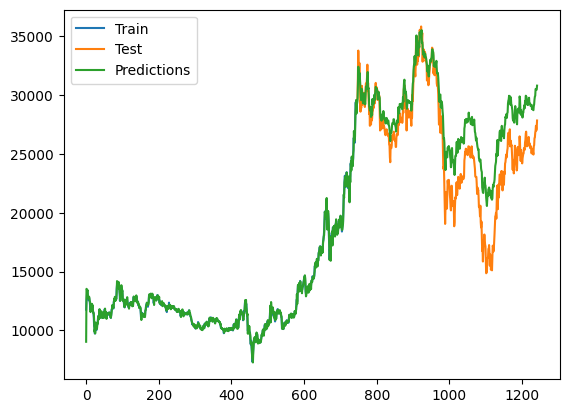

In [18]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val_arimax - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_arimax - y_test)**2))
print('ARIMAX Validation RMSE:', valid_rmse)
print('ARIMAX Testing RMSE:', test_rmse)

valid_mape = np.mean(np.abs((y_pred_val_arimax - y_val) / y_val)) * 100
test_mape = np.mean(np.abs((y_pred_arimax - y_test) / y_test)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

valid_mae = np.mean(np.abs(y_pred_val_arimax - y_val))
test_mae = np.mean(np.abs(y_pred_arimax - y_test))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(df['Price'].index, y_pred_val_arimax)
# plt.plot(last_data,y_next_10_arima)
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()